# Tarea Pau Riera Guardia Machine Learning

El conjunto de datos que hay que utilizar para hacer las predicciones se basa en determinar el estado de unas bombas de agua a partir de unas 50 variables (numéricas, categóricas, etc). Es un conjunto de datos que tiene todas las dificultades que uno se puede encontrar en un conjunto de datos: missings, variables categóricas con una alta cardinalidad (muchos valores diferentes), etc.

La variable target determina los tipos de estados de las bombas (son tres). Por tanto, no vamos a aplicar modelos binarios (Si/No, Bueno/Malo, 1/0), si no multiclase. Y veréis que el número de elementos de cada clase no está balanceado. Las bombas pueden estar en estos tres estados: Funcional, no -funcional y necesita_reparación.

In [260]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [261]:
# Importación de librerias

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, mean_squared_error, r2_score

# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

# Control de warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Análisis exploratorio de Datos (EDA)

El propósito es comprender la estructura, distribución y calidad de los datos, así como identificar patrones, errores o relaciones que guiarán las decisiones posteriores de preprocesamiento y modelado.

### 1.1. Carga y visión general del dataset

In [262]:
# Carga de datos
pd.set_option('display.max_columns', None)
df_test = pd.read_csv('/content/drive/MyDrive/Universidad /4) MÁSTER EN DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS (UCM)/MÓDULO 8_MACHINE LEARNING/Tarea/datos/test_set_values.csv')
training_set_values = pd.read_csv('/content/drive/MyDrive/Universidad /4) MÁSTER EN DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS (UCM)/MÓDULO 8_MACHINE LEARNING/Tarea/datos/training_set_values.csv')
training_set_labels = pd.read_csv('/content/drive/MyDrive/Universidad /4) MÁSTER EN DATA SCIENCE, BIG DATA & BUSINESS ANALYTICS (UCM)/MÓDULO 8_MACHINE LEARNING/Tarea/datos/training_set_labels.csv')

#### 1.1.1 Training dataset

Primeramente vamos a analizar los datasets que nos encontramos, en primer lugar vamos a ver el más importante, la variable target del dataset de training
(training_set_labels).

In [263]:
# Vemos las distribuciones de la variable y
training_set_labels['status_group'].value_counts()


,count
status_group,
functional,32259
non functional,22824
functional needs repair,4317


Obervamos que hay 3 opciones de target:
* Functional
* Non Functional
* Funcionatl needs repair

Pasamos a analizar el training_set_values

In [264]:
training_set_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Vemos que el data set tiene una variable id, con lo cual podemos unir los data sets por esta variable y tiene 39 variables más, donde hay un gran número de variables object (categoricas) que deberemos tratar. Vamos a ver la coincidencia de los ids para asegurarnos que podemos hacer un merge de ambos datasets.

In [265]:
training_set_values['id'].isin(training_set_labels['id']).value_counts()

,count
id,
True,59400


In [266]:
training_set_labels['id'].isin(training_set_values['id']).value_counts()

,count
id,
True,59400


Vemos que efectivamente todos los ids de training_set_values se encuentran en labels. Por lo tanto, podemos hacer el merge.

In [267]:
# Hacemos el merge
df_training = pd.merge(training_set_values,training_set_labels, on = ['id'], how='left' )

In [268]:
df_training.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [269]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

#### 1.1.2 Tabla test

In [270]:
df_test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [271]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

En esta tabla observamos los datos de testeo que deberemos utilizar posteriormente para realizar la predicción en función de nuestro modelo.

#### 1.1.3 Vision general

Una vez tenemos los datos de entrenamiento y los de testeo, pasamos a realiza la visión general del dataset.

In [272]:
print("Dimensiones del dataset training:", df_training.shape)
print("Dimensiones del dataset test:", df_test.shape)


Dimensiones del dataset training: (59400, 41)
Dimensiones del dataset test: (14850, 40)


Vemos que, según el problema, los datos cuadran.

Encontramos por un lado 59.400 variables con 41 categorias distintas, y, en el dataset de testeo 14850 variables con 40 categorias (una menos), pues la variable a predecir (status_group) no debe figurar en el conjunto de testeo.

In [273]:
# Información básica del dataset
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [274]:
# Información básica del dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13980 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

Observamos los distintos features de cada dataset y, efectivamente, confirmamos la existencia de 40 features en el testeo y 41 en el entrenamiento. La gran mayoría de datos son de tipo categórico, con lo cual, tendremos un trabajo importante en la numerización de las variables categoricas, donde deberemos aplicar distintas técnicas aprendidas durante el módulo.

In [275]:
# Identificación de tipos de variables
df_training.dtypes.value_counts()

,count
object,31
int64,7
float64,3


In [276]:
# Identificación de tipos de variables
df_test.dtypes.value_counts()

,count
object,30
int64,7
float64,3


Concretamente, encontramos 30 variables categóricas y 10 variables numéricas. Vayamos ahora a separar las variables entre categoricas y numéricas, asi como a identificar la variable target del dataset de entrenamiento. En el caso del dataset de training encontramos una variable categórica mas, precisamente la variable objetivo.

In [277]:
# Identificación del target y separación de variables predictoras
target_col = "status_group"
features = [col for col in df_training.columns if col != target_col]

# Clasificación de variables por tipo
num_features_training = df_training.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features_training = df_training.select_dtypes(include=["object", "category"]).columns.tolist()
num_features_test = df_test.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features_test = df_test.select_dtypes(include=["object", "category"]).columns.tolist()


print("Columna target:", target_col)
print("Número de variables sin contar variable objetivo:",len(features))
print("Número de variables numéricas training:", len(num_features_training))
print("Número de variables categóricas training:", len(cat_features_training))
print("Número de variables numéricas test:", len(num_features_test))
print("Número de variables categóricas test:", len(cat_features_test))

Columna target: status_group
Número de variables sin contar variable objetivo: 40
Número de variables numéricas training: 10
Número de variables categóricas training: 31
Número de variables numéricas test: 10
Número de variables categóricas test: 30


Corroboramos la clasificación anterior entre variables numericas y variables categoricas, definiendo a su vez, la columna target.

### 1.2. Estadisticas descriptivas

Vamos a analizar el comportamiento individual de las variables, tanto numéricas como categóricas, para entender su rango, dispersión, asimetría y valores característicos.

In [278]:
# Estadísticas descriptivas para variables numéricas
print("Estadísticas descriptivas para variables numéricas training:")
df_training[num_features_training].describe()


Estadísticas descriptivas para variables numéricas training:


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [279]:
print("Estadísticas descriptivas para variables numéricas test:")
df_test[num_features_test].describe()

Estadísticas descriptivas para variables numéricas test:


,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,14850.000000,14850.000000,14850.000000,14850.000000,1.485000e+04,14850.000000,14850.000000,14850.000000,14850.000000,14850.000000
mean,37161.972929,322.826983,655.147609,34.061605,-5.684724e+00,0.415084,15.139057,5.626397,184.114209,1289.708350
std,21359.364833,2510.968644,691.261185,6.593034,2.940803e+00,8.167910,17.191329,9.673842,469.499332,955.241087
min,10.000000,0.000000,-57.000000,0.000000,-1.156459e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18727.000000,0.000000,0.000000,33.069455,-8.443970e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37361.500000,0.000000,344.000000,34.901215,-5.049750e+00,0.000000,12.000000,3.000000,20.000000,1986.000000
75%,55799.750000,25.000000,1308.000000,37.196594,-3.320594e+00,0.000000,17.000000,5.000000,220.000000,2004.000000
max,74249.000000,200000.000000,2777.000000,40.325016,-2.000000e-08,669.000000,99.000000,80.000000,11469.000000,2013.000000


En primer lugar, al analizar las estadísticas descriptivas de las variables numéricas tanto del conjunto de entrenamiento como del de test, se observa que ambos presentan comportamientos muy similares en términos de media, desviación estándar y rangos de valores. Esto indica que los dos conjuntos parecen proceder de la misma distribución, sin cambios importantes en la estructura de los datos entre training y test, lo cual es fundamental para poder generalizar bien el modelo.

Sin embargo, al entrar en detalle en algunas variables numéricas, se detectan patrones que conviene tener en cuenta. En `amount_tsh`, por ejemplo, la mediana y el percentil 25 son 0 tanto en training como en test, mientras que el máximo alcanza valores muy elevados (hasta 350.000 en training y 200.000 en test). Esto sugiere una distribución muy asimétrica, con muchos registros sin información o con valor por defecto igual a 0 y unos pocos registros con valores extremadamente altos, que actúan como outliers. Algo similar ocurre con `gps_height`, donde aparecen alturas negativas y muchos ceros, lo que apunta a posibles errores o a una codificación de “dato desconocido” como 0. La variable `population` también presenta un gran número de ceros y unos cuantos valores muy elevados, lo que vuelve a indicar una fuerte asimetría y la presencia de outliers. En `construction_year` se observa que una parte importante de los registros tiene año 0, claramente irreal, mientras que el resto se concentra en años recientes (a partir de los años 80), por lo que ese valor 0 puede interpretarse como año desconocido más que como un dato válido.

En cuanto a las coordenadas geográficas (`longitude` y `latitude`), los rangos generales son coherentes con la ubicación real de Tanzania, pero se aprecian también valores 0 en alguna de las coordenadas, que probablemente representan registros mal georreferenciados o datos faltantes. Por otro lado, variables como `region_code` y `district_code`, aunque estén almacenadas como numéricas, en realidad funcionan como códigos categóricos, ya que representan identificadores de zonas administrativas y no cantidades continuas.

In [280]:
# Estadísticas descriptivas para variables categóricas
print("Estadísticas descriptivas para variables categóricas training:")
df_training[cat_features_training].describe()



Estadísticas descriptivas para variables categóricas training:


,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55763,55745,59398,59400,59029,59400,59400,59400,56066,59400,55522,30590,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1896,2145,37399,9,19287,21,125,2092,2,1,11,2695,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


In [281]:
print("Estadísticas descriptivas para variables categóricas test:")
df_test[cat_features_test].describe()


Estadísticas descriptivas para variables categóricas test:


,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,14850,13980,13973,14850,14850,14751,14850,14850,14850,14029,14850,13881,7608,14113,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850,14850
unique,331,979,1091,10840,9,8443,21,125,1959,2,1,11,1788,2,17,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2013-02-03,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Shinyanga,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,communal standpipe,communal standpipe
freq,138,2215,4349,877,2623,140,1311,625,79,12738,14850,9124,176,9754,6483,6483,6483,10117,13048,6364,6364,12687,12687,8336,8336,4316,4316,11492,7106,8614


Respecto a las variables categóricas, las estadísticas descriptivas muestran una cardinalidad muy elevada en columnas como `funder`, `installer`, `wpt_name` o `subvillage`, con miles de categorías distintas y una larga cola de valores poco frecuentes. Esto implica que una codificación directa mediante one-hot encoding generaría un número de columnas enorme, por lo que será necesario emplear estrategias como agrupar categorías raras, usar codificación por frecuencia o aplicar técnicas de reducción. También se identifican variables poco informativas, como `recorded_by`, que prácticamente toma un único valor en todo el conjunto de datos y, por tanto, no aporta información útil al modelo y podría eliminarse sin problema. Además, algunas variables categóricas de tipo booleano o similar, como `public_meeting` o `permit`, presentan menos registros válidos que el total de filas, lo que indica la existencia de valores desconocidos que habrá que imputar o tratar explícitamente como una categoría adicional.

In [282]:
# Distribución de frecuencias para variables categóricas
print("Distribución de frecuencias para variables categóricas training:")
for col in cat_features_training:
    print(f"\nDistribución de {col}:")
    print(df_training[col].value_counts(normalize=True).head())


Distribución de frecuencias para variables categóricas training:

Distribución de date_recorded:
date_recorded
2011-03-15    0.009630
2011-03-17    0.009394
2013-02-03    0.009192
2011-03-14    0.008754
2011-03-16    0.008636
Name: proportion, dtype: float64

Distribución de funder:
funder
Government Of Tanzania    0.162904
Danida                    0.055843
Hesawa                    0.039489
Rwssp                     0.024640
World Bank                0.024192
Name: proportion, dtype: float64

Distribución de installer:
installer
DWE           0.312171
Government    0.032738
RWE           0.021634
Commu         0.019015
DANIDA        0.018836
Name: proportion, dtype: float64

Distribución de wpt_name:
wpt_name
none         0.059985
Shuleni      0.029429
Zahanati     0.013974
Msikitini    0.009007
Kanisani     0.005438
Name: proportion, dtype: float64

Distribución de basin:
basin
Lake Victoria      0.172525
Pangani            0.150505
Rufiji             0.134276
Internal           0.1

In [283]:
print("Distribución de frecuencias para variables categóricas test:")
for col in cat_features_test:
    print(f"\nDistribución de {col}:")
    print(df_test[col].value_counts(normalize=True).head())

Distribución de frecuencias para variables categóricas test:

Distribución de date_recorded:
date_recorded
2013-02-03    0.009293
2011-03-17    0.009226
2011-03-16    0.009226
2011-03-18    0.008754
2011-03-14    0.008687
Name: proportion, dtype: float64

Distribución de funder:
funder
Government Of Tanzania    0.158441
Danida                    0.056724
Hesawa                    0.041488
World Bank                0.025179
Kkkt                      0.024034
Name: proportion, dtype: float64

Distribución de installer:
installer
DWE           0.311243
Government    0.032706
RWE           0.020897
Commu         0.020540
DANIDA        0.018249
Name: proportion, dtype: float64

Distribución de wpt_name:
wpt_name
none         0.059057
Shuleni      0.029293
Zahanati     0.013737
Msikitini    0.007542
Sokoni       0.004579
Name: proportion, dtype: float64

Distribución de basin:
basin
Lake Victoria      0.176633
Pangani            0.148350
Rufiji             0.135421
Internal           0.12505

En cuanto a las variables categóricas, las distribuciones de frecuencias son muy similares entre los conjuntos de entrenamiento y test: las mismas categorías tienden a ser mayoritarias en ambos, lo que indica que el modelo se enfrentará en producción a un patrón de datos muy parecido al visto en entrenamiento. Por ejemplo, en variables como `funder`, `installer`, `basin`, `management_group` o `payment` se observa que un pequeño grupo de categorías concentra gran parte de los registros, mientras que el resto se reparte en muchas categorías con muy poca presencia.

Este patrón de “pocas categorías dominantes y muchas categorías raras” sugiere que, además de decidir cómo codificar las variables, será importante valorar si ciertas categorías poco frecuentes deben reagruparse para evitar problemas de sobreajuste. También se aprecia que algunas variables capturan información claramente estructural (por ejemplo, `basin`, `region`, `management_group`), lo que probablemente aporte señal relevante al modelo, mientras que otras resultan menos diferenciadoras o prácticamente constantes, como `recorded_by`, por lo que su contribución será muy limitada. Finalmente, variables como `public_meeting` o `permit` combinan valores True y False con un cierto número de “desconocidos”, lo que obliga a definir una estrategia clara de tratamiento (imputación o creación de una categoría específica) para mantener la coherencia entre training y test.

### 1.3. Valors faltantes, duplicados y outliers

Evaluar la calidad del dataset identificando valores faltantes, registros duplicados y valores atipicos (outliers).

In [284]:
# Cálculo del porcentaje de valores faltantes por variable
missing_count = df_training.isnull().sum()
missing_pct = (missing_count / len(df_training)) * 100

missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_pct": missing_pct
}).sort_values("missing_pct", ascending=False)

print("Valores faltantes por variable training:")
display(missing_df[missing_df["missing_count"] > 0])

Valores faltantes por variable training:


,missing_count,missing_pct
scheme_name,28810,48.501684
scheme_management,3878,6.528620
installer,3655,6.153199
funder,3637,6.122896
public_meeting,3334,5.612795
permit,3056,5.144781
subvillage,371,0.624579
wpt_name,2,0.003367


In [285]:
# Cálculo del porcentaje de valores faltantes por variable
missing_count = df_test.isnull().sum()
missing_pct = (missing_count / len(df_test)) * 100

missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_pct": missing_pct
}).sort_values("missing_pct", ascending=False)

print("Valores faltantes por variable test:")
display(missing_df[missing_df["missing_count"] > 0])

Valores faltantes por variable test:


,missing_count,missing_pct
scheme_name,7242,48.767677
scheme_management,969,6.525253
installer,877,5.905724
funder,870,5.858586
public_meeting,821,5.528620
permit,737,4.962963
subvillage,99,0.666667


Al analizar el porcentaje de valores faltantes por variable en los conjuntos de training y test, se observa que la mayoría de columnas no presentan nulos, pero existe un grupo concreto de variables con un volumen relevante de datos ausentes. La más afectada es `scheme_name`, que concentra aproximadamente un 48% de valores faltantes, lo que indica que en casi la mitad de los registros no se ha documentado el nombre del esquema. También aparecen huecos en variables como `installer`, `funder` y `subvillage`, todas ellas de alta cardinalidad, donde una parte de los pozos carece de información sobre quién los instaló, financió o el subpueblo asociado. A esto se suman nulos en `scheme_management`, así como en las variables de tipo booleano `public_meeting` y `permit`, donde no siempre se ha registrado si existía una reunión pública o un permiso asociado.

Aunque estas faltas no son tan masivas como en `scheme_name`, sí son lo suficientemente relevantes como para requerir una estrategia específica de tratamiento, ya sea mediante imputación (por ejemplo, con la categoría más frecuente) o mediante la creación de una categoría adicional que represente la ausencia de información (p. ej. “Unknown”). Además, aunque las variables numéricas no presentan nulos explícitos, algunas de ellas contienen valores que en la práctica actúan como faltantes encubiertos, como `gps_height` igual a 0 o negativa, `population` igual a 0 o `construction_year` igual a 0, que difícilmente pueden interpretarse como valores reales. Es importante tener en cuenta estos casos en el preprocesado. Por último, el patrón de valores faltantes es muy similar en training y test, lo que permite aplicar una misma estrategia de imputación en ambos conjuntos sin introducir inconsistencias en la fase de predicción.

In [286]:
# Detección de duplicados training
num_duplicated = df_training.duplicated().sum()
print(f"Número de filas duplicadas training: {num_duplicated}")

Número de filas duplicadas training: 0


In [287]:
# Detección de duplicados test
num_duplicated = df_test.duplicated().sum()
print(f"Número de filas duplicadas test: {num_duplicated}")

Número de filas duplicadas test: 0


En relación a los duplicados, no existen en ninguno de los dos conjuntos de datos. Por lo tanto, no tendrá tratamiento.

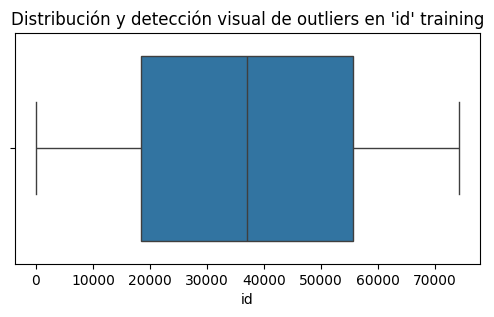

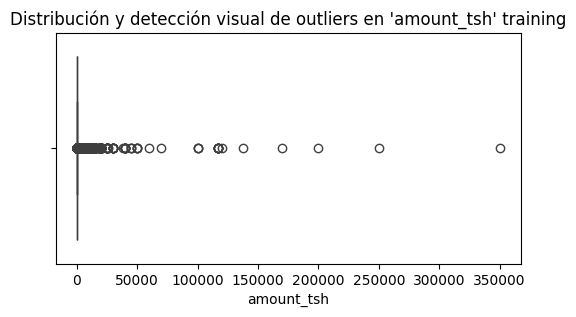

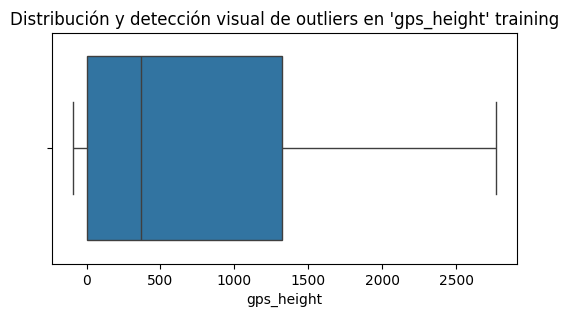

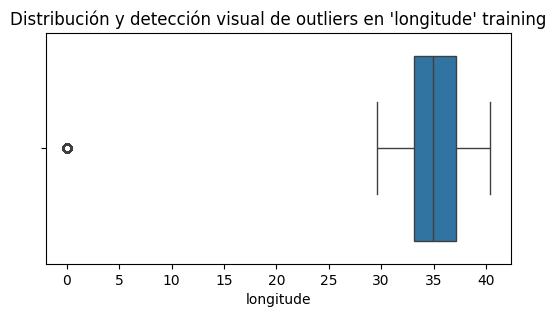

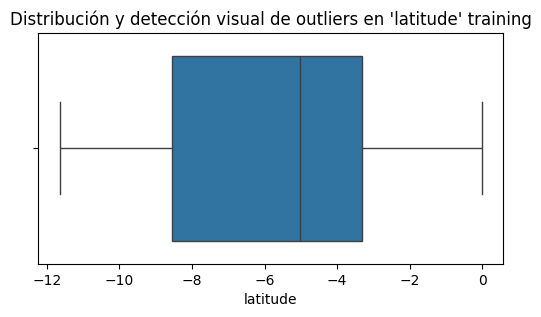

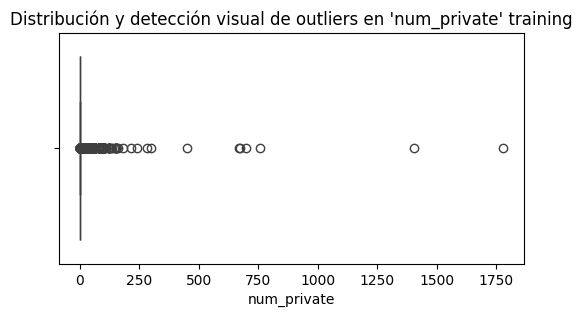

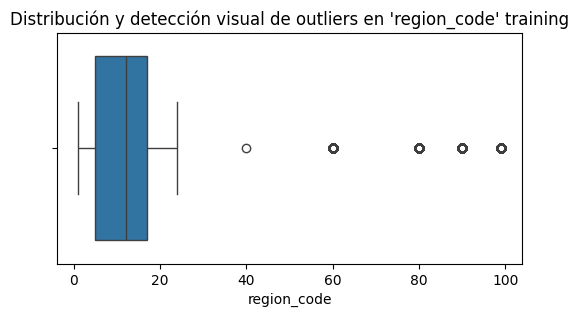

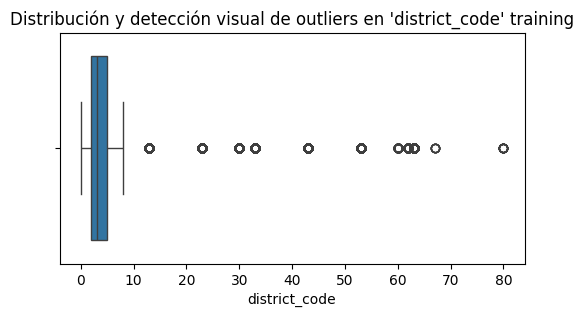

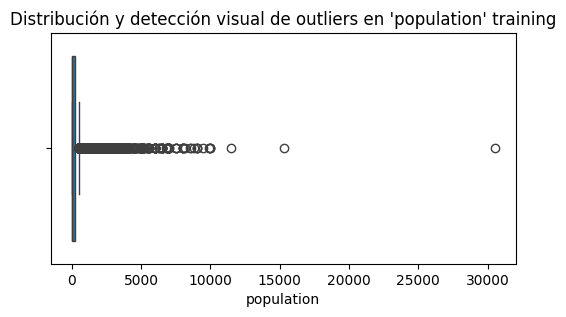

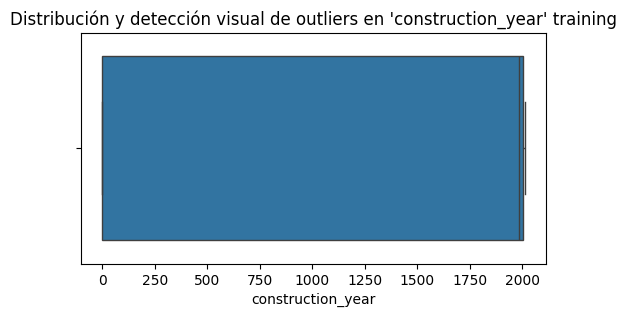

In [288]:
# Detección visual de outliers con boxplot training
import matplotlib.pyplot as plt
import seaborn as sns

for col in num_features_training:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_training[col])
    plt.title(f"Distribución y detección visual de outliers en '{col}' training")
    plt.show()

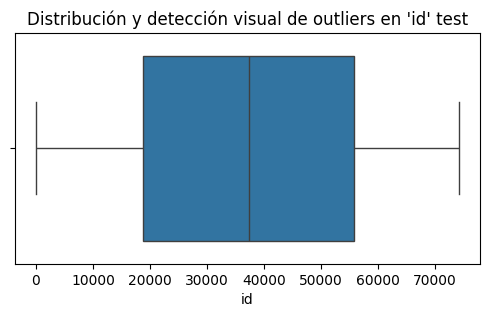

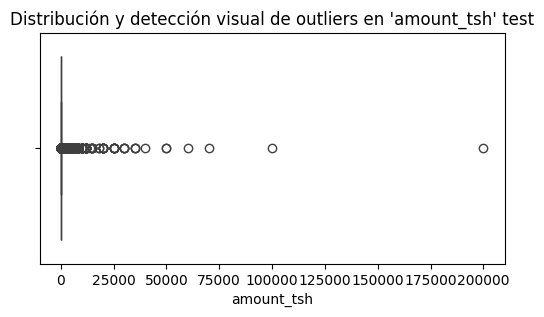

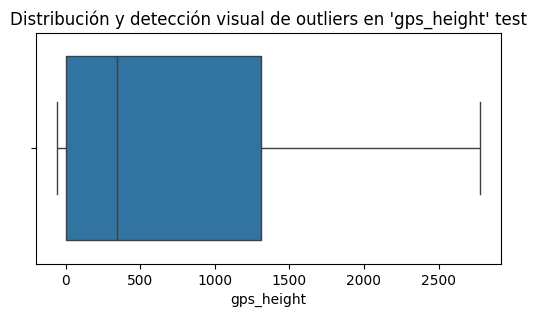

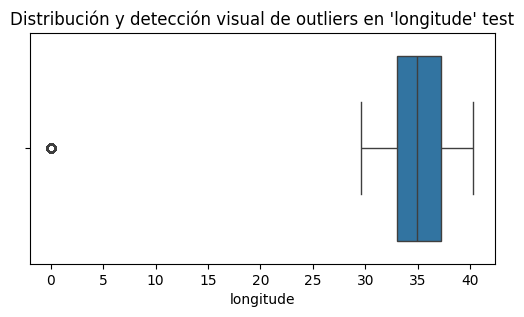

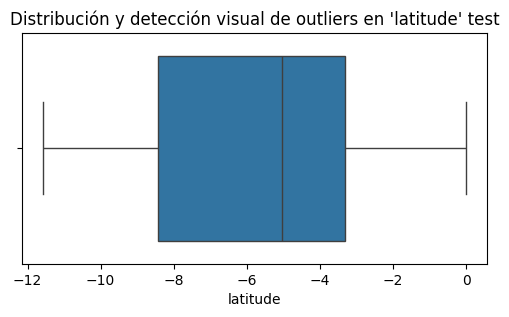

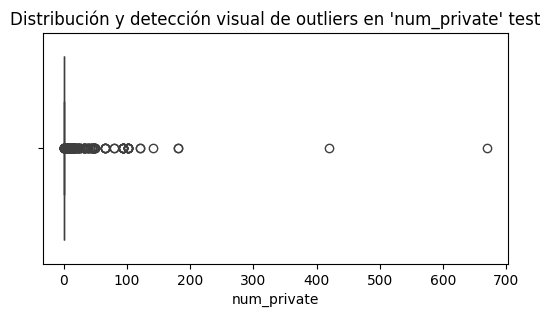

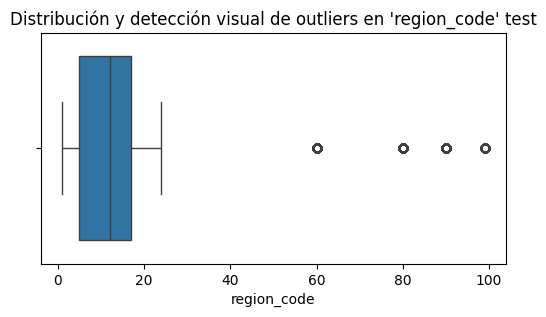

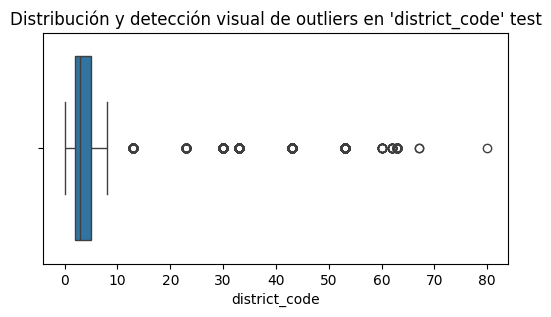

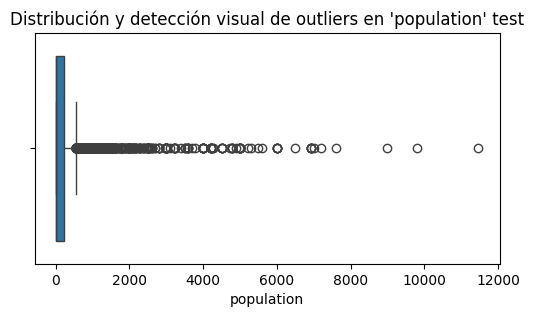

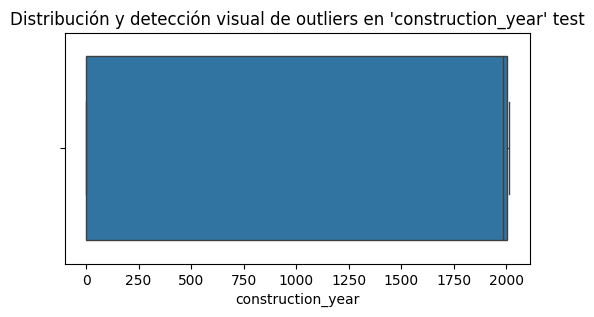

In [289]:
# Detección visual de outliers con boxplot test
import matplotlib.pyplot as plt
import seaborn as sns

for col in num_features_training:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_test[col])
    plt.title(f"Distribución y detección visual de outliers en '{col}' test")
    plt.show()

Al revisar la presencia de outliers en las variables numéricas, se observa que varias de ellas presentan valores extremos que se alejan notablemente del comportamiento general del resto de los datos. Esto ocurre especialmente en variables como `amount_tsh`, `population` y `gps_height`, donde la diferencia entre los percentiles superiores y los valores máximos es muy elevada, lo que indica la existencia de colas largas y puntos extremadamente atípicos. En `amount_tsh`, por ejemplo, mientras que la mayoría de registros tienen valores bajos o incluso 0, existen unos pocos casos que alcanzan cifras muy elevadas (hasta cientos de miles), lo que genera una fuerte asimetría. Algo similar sucede en `population`, donde la mayor parte de los pozos registran poblaciones pequeñas o nulas, pero algunos alcanzan valores muy altos, lo cual sugiere que conviven pozos en zonas rurales muy dispersas con otros en núcleos mucho más poblados.

En el caso de `gps_height`, además de valores extremadamente altos, también aparecen valores negativos, lo que no resulta coherente con una altitud real y probablemente indica errores de medición o registros incorrectos. Estos valores, aun no siendo nulos explícitos, deben considerarse casos atípicos que requieren tratamiento. La presencia de este tipo de outliers puede afectar modelos sensibles a escalas y distribuciones, provocando sesgos o aumentando la variabilidad de los resultados. Sin embargo, dado que muchos algoritmos basados en árboles toleran bien la existencia de valores extremos, la necesidad de tratarlos dependerá en parte del tipo de modelo que se vaya a emplear.

En conjunto, las distribuciones muestran que los outliers forman parte natural del dataset y, en muchos casos, probablemente reflejan situaciones reales (por ejemplo, poblaciones muy grandes o niveles de `amount_tsh` poco comunes). Por ello, más que eliminarlos sistemáticamente, será necesario evaluar caso por caso si conviene aplicar transformaciones (como logaritmos), recortes moderados, o simplemente dejar los valores tal cual si el modelo seleccionado lo permite.

### 1.4. Correlaciones y relaciones entre variables

Identificar relaciones entre las variables numéricas y detectar redundancias o asociaciones relevantes con el target.

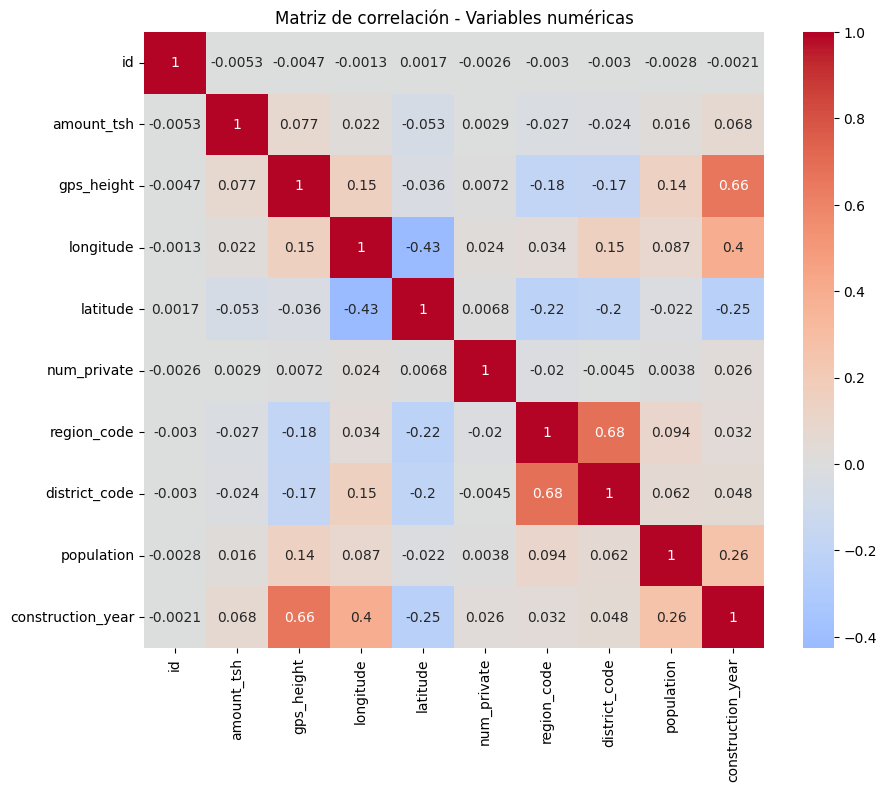

In [290]:
# Matriz de  training
corr_matrix = df_training[num_features_training].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlación - Variables numéricas")
plt.show()

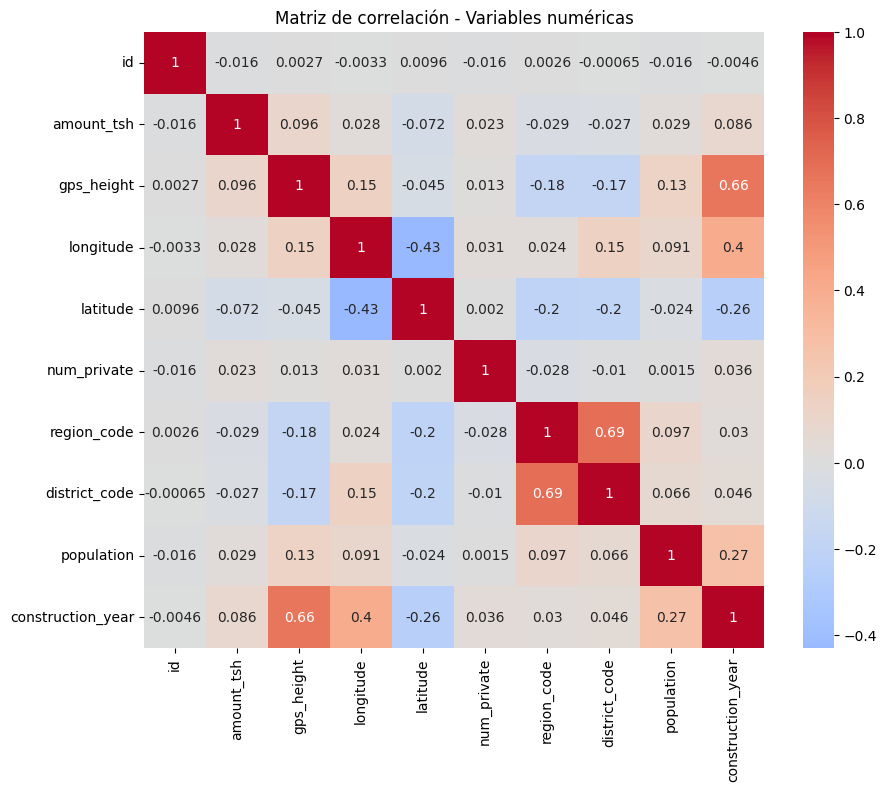

In [291]:
# Matriz de test
corr_matrix = df_test[num_features_test].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matriz de correlación - Variables numéricas")
plt.show()

El análisis de la matriz de correlación entre las variables numéricas muestra que, en general, no existen relaciones lineales fuertes entre la mayoría de los atributos. La gran parte de las correlaciones se sitúan en valores bajos o moderados, lo que indica que las variables numéricas aportan información relativamente independiente entre sí y no existe un grupo dominante de variables altamente redundantes.

###1.5. Análisis del target

Analizar el comportamiento de la variable objetivo (target), ya que su naturaleza condiciona el tipo de modelo, las métricas de evaluación y la estrategia de entrenamiento.

Distribución del target (clasificación):
status_group
functional                 54.308081
non functional             38.424242
functional needs repair     7.267677
Name: proportion, dtype: float64


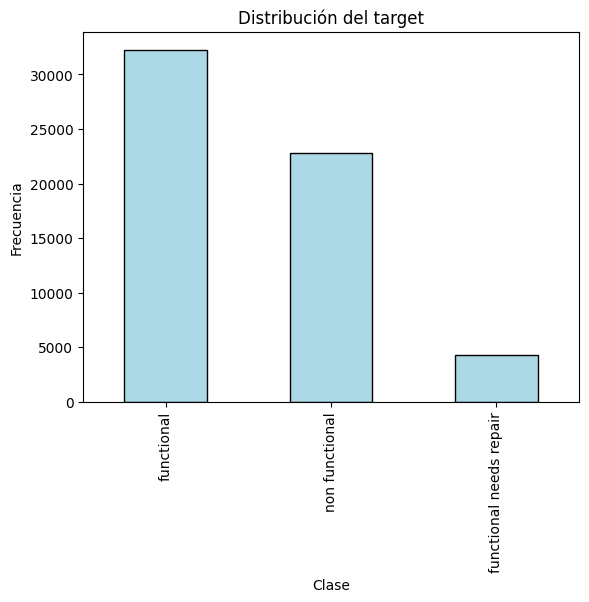

In [292]:
# CLASIFICACIÓN : distribución de clases
print("Distribución del target (clasificación):")
print(df_training[target_col].value_counts(normalize=True) * 100)

df_training[target_col].value_counts().plot(kind="bar", color="lightblue", edgecolor="black")
plt.title("Distribución del target")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

El análisis de la variable objetivo muestra que las tres clases —functional, non functional y functional needs repair— no se encuentran equilibradas. La clase mayoritaria es functional, que representa algo más de la mitad de los registros. En segundo lugar aparece non functional, con una proporción considerable pero claramente menor, mientras que la clase functional needs repair es la minoritaria con una presencia muy reducida en el dataset.

Esta distribución indica un problema evidente de desbalanceo de clases, especialmente debido a la escasa representación de la categoría “functional needs repair”. En un escenario de modelado, este desbalance puede llevar a que el modelo tienda a favorecer la clase mayoritaria, alcanzando aparentemente buenos resultados en métricas como la precisión global pero con un rendimiento deficiente en la detección de las clases menos frecuentes.

Por este motivo, será necesario tener en cuenta este desequilibrio durante el entrenamiento, ya sea mediante técnicas de ponderación de clases, sobremuestreo (como SMOTE), submuestreo de la clase mayoritaria, o utilizando métricas adecuadas que reflejen el rendimiento de manera equilibrada, como el F1-score, el macro F1 o la balanced accuracy. En definitiva, el análisis del target evidencia un reparto desigual que debe ser tratado correctamente para evitar que el modelo ignore las clases menos representadas, especialmente aquella que identifica los pozos que necesitan reparación.

## 2. Preprocesamiento de los Datos

El preprocesamiento es la fase donde los datos se limpian, transforman y preparan para ser utilizados por los algoritmos de Machine Learning.

El objetivo es garantizar que los datos sean coherentes, numéricamente comparables y relevantes para el modelo.

### 2.1. Tratamiento variables numéricas

Utilizando el EDA como referencia, y puesto que vamos a usar algoritmos de árboles (RandomForestClassifier y XGBoostClassifier), debemos tratar los valores numéricos en relación a los valores 0 que corresponde a valores faltantes. Estos valores son `amount_tsh`, `gps_height`, `population`, `construction_year` y `latitude` y `longitude`. En relación a la variable `num_private`, la eliminaremos, pues la mayoría de datos son 0. Las variables `region_code` y `district_code` eliminaremos una de ellas, pues presentan una alta correlación.

Antes de todo, vamos a hacer un recuento de los 0 existentes en cada una de las variables y considerar si es mejor realizar una imputación o eliminarlas.

In [293]:
# Conteo de ceros por variable numérica
zero_count = (df_training[num_features_training] == 0).sum()

# Porcentaje de ceros por variable numérica
zero_pct = ( zero_count / len(df_training)) * 100

# Crear el DataFrame resumen
zero_summary = pd.DataFrame({
    'zero_count': zero_count,
    'zero_pct': zero_pct
})

# Ordenarlo de mayor a menor porcentaje
zero_summary = zero_summary.sort_values('zero_pct', ascending=False)

zero_summary

,zero_count,zero_pct
num_private,58643,98.725589
amount_tsh,41639,70.099327
population,21381,35.994949
construction_year,20709,34.863636
gps_height,20438,34.407407
longitude,1812,3.050505
district_code,23,0.038721
id,1,0.001684
latitude,0,0.000000
region_code,0,0.000000


In [294]:
# Conteo de ceros por variable numérica
zero_count = (df_test[num_features_test] == 0).sum()

# Porcentaje de ceros por variable numérica
zero_pct = ( zero_count / len(df_test)) * 100

# Crear el DataFrame resumen
zero_summary = pd.DataFrame({
    'zero_count': zero_count,
    'zero_pct': zero_pct
})

# Ordenarlo de mayor a menor porcentaje
zero_summary = zero_summary.sort_values('zero_pct', ascending=False)

zero_summary

,zero_count,zero_pct
num_private,14656,98.693603
amount_tsh,10410,70.101010
population,5453,36.720539
construction_year,5260,35.420875
gps_height,5211,35.090909
longitude,457,3.077441
district_code,4,0.026936
id,0,0.000000
latitude,0,0.000000
region_code,0,0.000000


Echando un ojo a los porcentajes, decidimos eliminar la variable `num_private` y la variable `distric_code`, pues la primera presenta un largo número de 0 y la segunda tiene una alta correlación con `region_code`. Respecto a la variable `amount_tsh` no eliminamos ni imputamos los 0 , pues puede ser que no exísta cantidad de agua en el pozo, por lo tanto, hay un 70% de los pozos sin agua.


In [295]:
# Dropeamos las columnas num_private y district_code de ambos datasets
df_training.drop(["num_private","district_code"],axis =1,inplace=True)
df_test.drop(["num_private","district_code"],axis =1,inplace=True)

Una vez dropeados las columnas numéricas que no necestiamos, vamos a imputar los valores 0 de las distintas variables numéricas que hemos decidido imputar mediante su media.

In [296]:
num_features_training

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year']

In [297]:
# Creamos una nueva lista con las variables numéricas que queremos imputar

num_features_training_imput = ['gps_height','longitude','latitude','region_code','population','construction_year']
num_features_test_imput = ['gps_height','longitude','latitude','region_code','population','construction_year']

In [298]:
# Definición de variables a imputar

# Imputación de valores numéricos con la media
for col in num_features_training_imput:
    mean_val = df_training.loc[df_training[col] != 0, col].mean()
    df_training[col] = df_training[col].replace(0, mean_val)

for col in num_features_test_imput:
    mean_val = df_test.loc[df_test[col] != 0, col].mean()
    df_test[col] = df_test[col].replace(0, mean_val)

In [299]:
(df_training[num_features_training_imput] == 0).sum()

,0
gps_height,0
longitude,0
latitude,0
region_code,0
population,0
construction_year,0


In [300]:
(df_test[num_features_test_imput] == 0).sum()

,0
gps_height,0
longitude,0
latitude,0
region_code,0
population,0
construction_year,0


In [301]:
df_training.describe()

,id,amount_tsh,gps_height,longitude,latitude,region_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,1018.860839,35.149669,-5.706033e+00,15.297003,281.087167,1996.814686
std,21453.128371,2997.574558,496.110517,2.567349,2.946019e+00,17.587406,451.765813,10.065781
min,0.000000,0.000000,-90.000000,29.607122,-1.164944e+01,1.000000,1.000000,1960.000000
25%,18519.750000,0.000000,903.000000,33.354079,-8.540621e+00,5.000000,100.000000,1996.000000
50%,37061.500000,0.000000,1018.860839,35.149669,-5.021597e+00,12.000000,281.087167,1996.814686
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,17.000000,281.087167,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,99.000000,30500.000000,2013.000000


In [302]:
df_test.describe()

,id,amount_tsh,gps_height,longitude,latitude,region_code,population,construction_year
count,14850.000000,14850.000000,14850.000000,14850.000000,1.485000e+04,14850.000000,14850.000000,14850.000000
mean,37161.972929,322.826983,1009.331051,35.143114,-5.684724e+00,15.139057,290.954134,1997.097914
std,21359.364833,2510.968644,495.766038,2.574431,2.940803e+00,17.191329,448.059761,9.892727
min,10.000000,0.000000,-57.000000,29.612776,-1.156459e+01,1.000000,1.000000,1960.000000
25%,18727.000000,0.000000,881.000000,33.326568,-8.443970e+00,5.000000,100.000000,1996.000000
50%,37361.500000,0.000000,1009.331051,35.143114,-5.049750e+00,12.000000,290.954134,1997.097914
75%,55799.750000,25.000000,1308.000000,37.196594,-3.320594e+00,17.000000,290.954134,2004.000000
max,74249.000000,200000.000000,2777.000000,40.325016,-2.000000e-08,99.000000,11469.000000,2013.000000


Ahora observamos que los valores numéricos no presentan irregularidades con los números 0. Todos aquellos 0 que realmente representaban un valor nulo han sido rellenados con la media decada variable. Ambos conjutnos presentan unidades parecidas.

### 2.2. Tratamiento variables categóricas

Una vez tratados los valores numéricos e imputados los valores 0 correspondientes mediante la media, debemos tratar los valores categóricos. Vamos a clasificar según el método que usaremos ara tratar dichas variables. Primeramente, vamos a dropear de los dataset la variable categórica `scheme_name`, pues un 48% de los registros tienen un valor n
umero.

In [303]:
df_training.drop("scheme_name",axis=1,inplace=True)
df_test.drop("scheme_name",axis=1,inplace=True)


Una vez dropeado, prodcedemos a tratar los valotres cagtegóricos que nos interesan y aplicamos los métodos adecuados para cada tipo de variable. Empezaremos aplicando el metodo <b>Rare Encoding</b> para las variables de alta cardinlalidad.

In [304]:
# Método: Rare Label Encoding

# Lista variables con alta cardinalidad
alta_cardinalidad = ['funder','installer','wpt_name','subvillage','lga','ward']

# Función rare encoding
def rare_encoding(df, columna, threshold=0.05, rare_label='Rare'):
    freq = df[columna].value_counts(normalize=True)
    categorias_frecuentes = list(freq[freq > threshold].index)
    df[columna] = np.where(df[columna].isin(categorias_frecuentes), df[columna], rare_label)
    return df


In [305]:
# Aplicamos en el dataset training
for col in alta_cardinalidad:
    df_training = rare_encoding(df_training, col, threshold=0.05, rare_label='Rare')

In [306]:
# Aplicamos en el dataset test
for col in alta_cardinalidad:
    df_test = rare_encoding(df_test, col, threshold=0.05, rare_label='Rare')

In [307]:
# Observamos ahora la cardinalidad de las variables que tenían alya cardinalidad
for col in alta_cardinalidad:
    print(f"\nDistribución de {col}:")
    print(df_training[col].value_counts(normalize=True).head())


Distribución de funder:
funder
Rare                      0.794646
Government Of Tanzania    0.152929
Danida                    0.052424
Name: proportion, dtype: float64

Distribución de installer:
installer
Rare    0.707037
DWE     0.292963
Name: proportion, dtype: float64

Distribución de wpt_name:
wpt_name
Rare    0.940017
none    0.059983
Name: proportion, dtype: float64

Distribución de subvillage:
subvillage
Rare    1.0
Name: proportion, dtype: float64

Distribución de lga:
lga
Rare    1.0
Name: proportion, dtype: float64

Distribución de ward:
ward
Rare    1.0
Name: proportion, dtype: float64


Observadas las cardinalidades ahora, podemos concluir que las variables `subvillage`, `lga` y `ward` no son necesarias, por lo tanto, las podemos eliminar. Para las variables `installer` y `wpt_name` aplicaremos Label encoding debido a su posible binariedad. Para la variable `funder` aplicaremos One-Hot encoding

In [308]:
df_training.drop(["subvillage","lga","ward"],axis=1,inplace=True)
df_test.drop(["subvillage","lga","ward"],axis=1,inplace=True)


Ahora vamos a aplicar el <b>one_hot_encoding</b> a aquellos valores que tienen cardinalidad

In [309]:
# Lista variables con cardinaldiad media
media_cardinalidad = [
 'funder',
 'basin',
 'region',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'scheme_management']

# Importación de la libreria
from sklearn.preprocessing import OneHotEncoder

# Definición de la función
def one_hot_encoding(df, columna):
    encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
    encoded = encoder.fit_transform(df[[columna]])

    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out([columna]),
        index=df.index
    )

    df_encoded = pd.concat([df.drop(columns=[columna]), encoded_df], axis=1)

    return df_encoded

In [310]:
# Aplicamos la función one_hot_encoding a las variables categóricas que tienen cardinalidad media al dataset training
for col in media_cardinalidad:
    df_training = one_hot_encoding(df_training, col)

In [311]:
# Aplicamos la función one_hot_encoding a las variables categóricas que tienen cardinalidad media al dataset test
for col in media_cardinalidad:
    df_test = one_hot_encoding(df_test, col)

Ahora vamos a aplicar <b>Label Encoding</b> a las variables binarias.

In [312]:
binarias = ["public_meeting","permit","installer","wpt_name"]

from sklearn.preprocessing import LabelEncoder

def label_encoder(df, columna):
    encoder = LabelEncoder()
    df[columna] = encoder.fit_transform(df[columna])
    return df

In [313]:
# Aplicamos en el dataframe de training
for col in binarias:
  df_training = label_encoder(df_training,col)

In [314]:
# Aplicamos en el dataframe de test
for col in binarias:
  df_test = label_encoder(df_test,col)

Vamos a tratar las ultimas variables categóricas.

In [315]:
df_training.select_dtypes(include="object")

,date_recorded,recorded_by,status_group
0,2011-03-14,GeoData Consultants Ltd,functional
1,2013-03-06,GeoData Consultants Ltd,functional
2,2013-02-25,GeoData Consultants Ltd,functional
3,2013-01-28,GeoData Consultants Ltd,non functional
4,2011-07-13,GeoData Consultants Ltd,functional
...,...,...,...
59395,2013-05-03,GeoData Consultants Ltd,functional
59396,2011-05-07,GeoData Consultants Ltd,functional
59397,2011-04-11,GeoData Consultants Ltd,functional
59398,2011-03-08,GeoData Consultants Ltd,functional


In [316]:
df_training["recorded_by"].value_counts()

,count
recorded_by,
GeoData Consultants Ltd,59400


In [317]:
df_test["recorded_by"].value_counts()

,count
recorded_by,
GeoData Consultants Ltd,14850


Como observamos, la variable `recorded_by` es siempre la misma categoria, la eliminamos, pues no nos aporta información.

In [318]:
df_training.drop("recorded_by",axis=1,inplace=True)

In [319]:
df_test.drop("recorded_by",axis=1,inplace=True)

Una vez dropeado, vamos a tratar las variable `date_recorded`.

In [320]:
# Convertimos la variable en formato datetime
df_training["date_recorded"] = pd.to_datetime(df_training["date_recorded"])
df_test["date_recorded"] = pd.to_datetime(df_test["date_recorded"])

In [321]:
# Extraemos anyo, mes y dia
df_training["year_recorded"] = df_training["date_recorded"].dt.year
df_training["month_recorded"] = df_training["date_recorded"].dt.month
df_training["day_recorded"] = df_training["date_recorded"].dt.day
df_test["year_recorded"] = df_test["date_recorded"].dt.year
df_test["month_recorded"] = df_test["date_recorded"].dt.month
df_test["day_recorded"] = df_test["date_recorded"].dt.day


In [322]:
# Eliminamos columna date_recored
df_training.drop("date_recorded",axis=1,inplace=True)
df_test.drop("date_recorded",axis=1,inplace=True)

Ahora que ya tenemos tratadas todas las variables categoricas y numéricas, debemos tratar la variable `status_group`, la target, del dataframe training. Para ello, aplicaremos <b>Label Encoding</b>.

In [323]:
df_training["status_group"].value_counts()

,count
status_group,
functional,32259
non functional,22824
functional needs repair,4317


In [324]:
df_training = label_encoder(df_training,"status_group")

In [325]:
df_training["status_group"].value_counts()

,count
status_group,
0,32259
2,22824
1,4317


Finalmente, vamos a eliminar el id, pues es una variable irrelevante.

In [326]:
df_training.drop("id",axis=1, inplace=True)
ids_test = df_test["id"] # Guardamos ids de test, pues lo necesitaremos para la entrega
X_test = df_test.drop("id",axis=1)

## 3. Muestreo y División del Dataset

La fase de muestreo y división del dataset tiene como objetivo evaluar el rendimiento real del modelo, garantizando que aprenda correctamente son sobreajuste a los datos de entrenamiento.

Para ello, debemos separar los datos de training la variable target y las variables explicativas.

In [327]:
y_train = df_training["status_group"]
X_train = df_training.drop("status_group",axis=1)

## 4. Modelado

Una vez tenemos los datos separados en train, test, y la variable y separada de las variables explicativas, podemos aplicar el modelo. En nuestro caso, aplicaremos un `RandomForestClassifier`, pues se trata de un modelo de clasificación multiclase. Antes de modelar, debemos comprobar que ambos conjuntos de X en train y test tienen las mismas variables.

In [328]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Columns: 165 entries, amount_tsh to day_recorded
dtypes: float64(157), int32(3), int64(5)
memory usage: 74.1 MB


In [329]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Columns: 164 entries, amount_tsh to day_recorded
dtypes: float64(156), int32(3), int64(5)
memory usage: 18.4 MB


Vemos que existe una columna más en el dataset de training que en el de test, veamos de que columna se trata.

In [330]:
set(X_train.columns) - set(X_test.columns)

{'extraction_type_other - mkulima/shinyanga'}

La columna que falta es `extraction_type_other`. Esta NO se ha generado en el dataset test al aplicar el one_hot_encoding, puesto que, la subcategoria `extraction_type_other` no se encuentra en el dataset de test. Por lo tanto, podemos determinarla como irrelevante y eliminarla.

In [331]:
X_train.drop("extraction_type_other - mkulima/shinyanga",axis=1,inplace=True)

In [332]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Columns: 164 entries, amount_tsh to day_recorded
dtypes: float64(156), int32(3), int64(5)
memory usage: 73.6 MB


In [333]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Columns: 164 entries, amount_tsh to day_recorded
dtypes: float64(156), int32(3), int64(5)
memory usage: 18.4 MB


Ahora si tenemos el mismo número de columnas y por lo tanto podemos entrenar el modelo. Vamos a probar con el <b>Random Forest</b>

In [334]:
# Importación de librerias
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# 1. Definción del modelo
rf_clf = RandomForestClassifier(
    n_estimators=200, # Número de árboles, cuantos más árboles, más estable y precisa será la predicción
    max_depth=5, # profundiad máxima del árbol
    random_state=42, # Semilla aleatoria reproducible
    n_jobs=-1, # número de núcleos del procesador que se usarán, n_jobs=-1 significa que se utilizarán todos los núcleos disponibles
    min_samples_leaf = 5 # Número mínimo de muestras requeridas en cada hoja: valores mayores suavizan el modelo y reducen el sobreajuste
)

# 2. Entrenamiento
rf_clf.fit(X_train, y_train)

# 3. Predicción
y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

In [335]:
# Convertimos las predicciones en los labels originales
map_back = {
    0: "functional",
    1: "non functional",
    2: "functional needs repair"
}

y_pred_labels = [map_back[p] for p in y_pred_rf]


In [336]:
submission = pd.DataFrame({
    "id": ids_test.values,
    "status_group": y_pred_labels
})

In [337]:
submission.head()

,id,status_group
0,50785,functional needs repair
1,51630,functional
2,17168,functional needs repair
3,45559,functional needs repair
4,49871,functional


In [338]:
submission.to_csv("submission.csv", index=False)

##5. Mejoras del modelo

Vamos a aplicar un feature importance para reducir el modelo a las variables más relevantes.

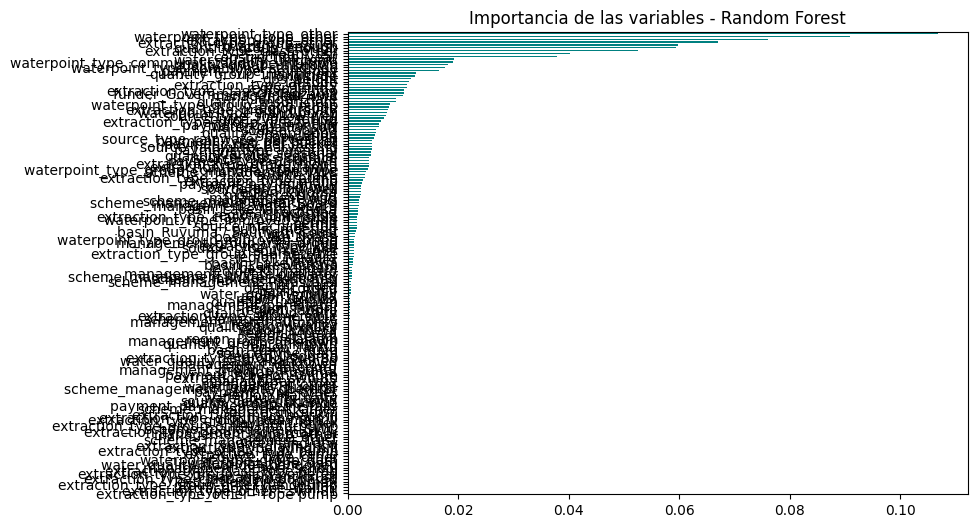

In [339]:
# Importación de variables
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf_clf.feature_importances_, index= X_train.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6), color='teal')
plt.title('Importancia de las variables - Random Forest')
plt.show()

Vamos a quedarnos con las 50 variables más importantes, pues la mayoría de variables tienen una importancia menor al 0.02.

In [340]:
# Selección de las 50 variables más importantes
top_n = 50
selected_features = importances.sort_values(ascending=True).head(top_n).index.tolist()

# Reducciión de los datasets a 50 variables más importantes
X_train_red = X_train[selected_features]
X_test_red  = X_test[selected_features]


In [341]:
# Importación de librerias
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# 1. Definción del modelo
rf_clf_1 = RandomForestClassifier(
    n_estimators=200, # Número de árboles, cuantos más árboles, más estable y precisa será la predicción
    max_depth=5, # profundiad máxima del árbol
    random_state=42, # Semilla aleatoria reproducible
    n_jobs=-1, # número de núcleos del procesador que se usarán, n_jobs=-1 significa que se utilizarán todos los núcleos disponibles
    min_samples_leaf = 5 # Número mínimo de muestras requeridas en cada hoja: valores mayores suavizan el modelo y reducen el sobreajuste
)

# 2. Entrenamiento
rf_clf_1.fit(X_train_red, y_train)

# 3. Predicción
y_pred_rf_1 = rf_clf_1.predict(X_test_red)
y_proba_rf_1 = rf_clf_1.predict_proba(X_test_red)[:, 1]

In [342]:
# Convertimos las predicciones en los labels originales
map_back = {
    0: "functional",
    1: "non functional",
    2: "functional needs repair"
}

y_pred_labels_1 = [map_back[p] for p in y_pred_rf_1]

In [343]:
submission_2 = pd.DataFrame({
    "id": ids_test.values,
    "status_group": y_pred_labels_1
})

In [344]:
submission_2.to_csv("submission_2.csv", index=False)

Ahora vamos a tratar de realizarlo usando otro tipo de modelo por ejemplo con `XGBoostClassifier`.